# 付録A14: リッチクラブ現象（Rich Club Phenomenon）

## 学習目標

この付録では、ネットワーク科学における「リッチクラブ現象」について学びます。

- リッチクラブ現象の定義と社会的意味を理解する
- リッチクラブ係数を計算・可視化する
- 正規化リッチクラブ係数でランダムネットワークと比較する
- 異なるネットワークタイプでのリッチクラブを分析する

## セットアップ

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import japanize_matplotlib

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['IPAexGothic'] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (10, 6)

# 再現性のための乱数シード
np.random.seed(42)
random.seed(42)

## A14.1 リッチクラブ現象とは

### 概念の定義

**リッチクラブ現象（Rich Club Phenomenon）** とは、ネットワーク内で高次数（多くの接続を持つ）ノード同士が、互いに密に接続する傾向のことです。

### 社会的アナロジー

- **富裕層のクラブ**: 富裕層は互いに交流し、排他的なネットワークを形成
- **エリートの結束**: 権力者や影響力のある人々は互いにつながりやすい
- **「持てる者がさらに持つ」**: マシュー効果の一種

### 優先的選択との違い

| 概念 | 説明 |
|------|------|
| 優先的選択 | 新規ノードが高次数ノードに接続しやすい |
| リッチクラブ | 高次数ノード**同士**が互いに接続している |

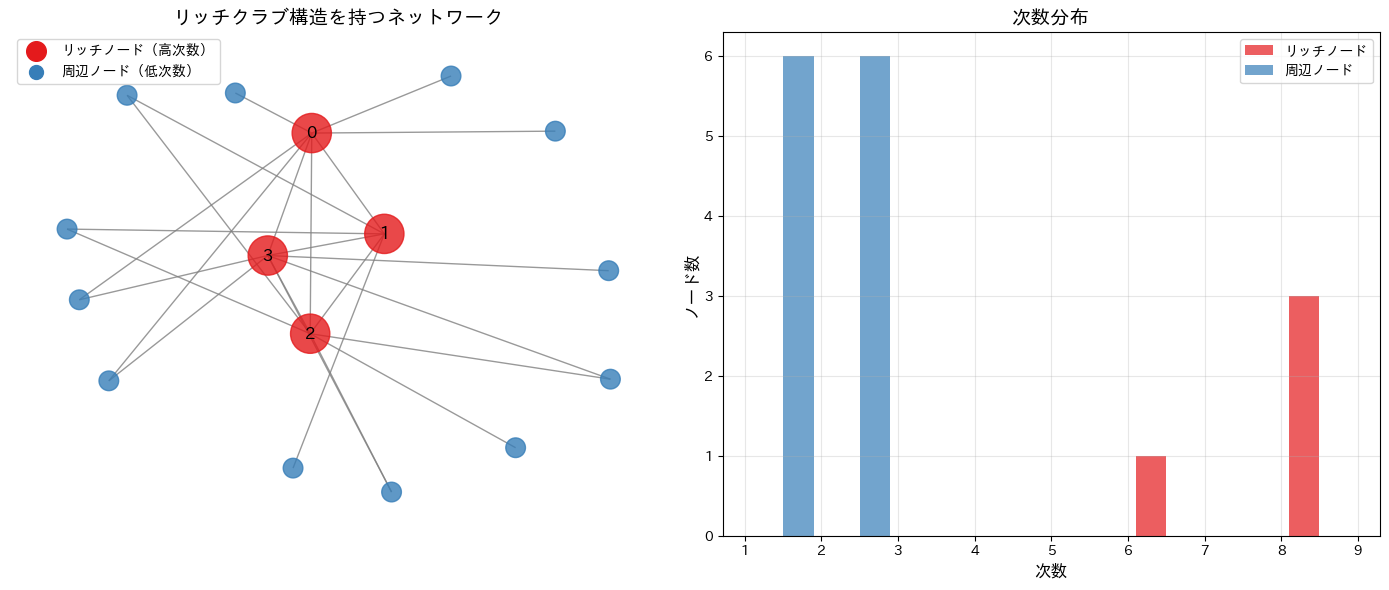

リッチクラブの特徴:
  リッチノード（赤）: 4個, 平均次数=7.5
  周辺ノード（青）: 12個, 平均次数=1.5

  リッチノード間のエッジ密度: 1.0（完全連結）
  周辺ノード間のエッジ密度: 0.0


In [2]:
# リッチクラブ現象の視覚的説明
def create_rich_club_example():
    """リッチクラブ構造を持つネットワークの例"""
    G = nx.Graph()
    
    # リッチクラブ（高次数ノード同士が密に接続）
    rich_nodes = [0, 1, 2, 3]
    for i in rich_nodes:
        for j in rich_nodes:
            if i < j:
                G.add_edge(i, j)
    
    # 周辺ノード（リッチノードに接続するが、互いには接続しない）
    peripheral_nodes = list(range(4, 16))
    for i, p in enumerate(peripheral_nodes):
        # 各周辺ノードは1-2個のリッチノードに接続
        rich_target = rich_nodes[i % len(rich_nodes)]
        G.add_edge(p, rich_target)
        if random.random() < 0.3:
            G.add_edge(p, rich_nodes[(i + 1) % len(rich_nodes)])
    
    return G, rich_nodes, peripheral_nodes

G_example, rich_nodes, peripheral_nodes = create_rich_club_example()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ネットワーク可視化
pos = nx.spring_layout(G_example, seed=42, k=2)

# リッチノードと周辺ノードで色分け
node_colors = ['#e41a1c' if n in rich_nodes else '#377eb8' for n in G_example.nodes()]
node_sizes = [800 if n in rich_nodes else 200 for n in G_example.nodes()]

nx.draw(G_example, pos, ax=axes[0], node_color=node_colors,
        node_size=node_sizes, edge_color='gray', alpha=0.8, width=1)

# ラベル（リッチノードのみ）
rich_labels = {n: str(n) for n in rich_nodes}
nx.draw_networkx_labels(G_example, pos, labels=rich_labels, ax=axes[0], font_size=12)

axes[0].set_title('リッチクラブ構造を持つネットワーク', fontsize=14)
axes[0].scatter([], [], c='#e41a1c', s=200, label='リッチノード（高次数）')
axes[0].scatter([], [], c='#377eb8', s=100, label='周辺ノード（低次数）')
axes[0].legend(loc='upper left')

# 次数分布
degrees = dict(G_example.degree())
degree_values = list(degrees.values())

rich_degrees = [degrees[n] for n in rich_nodes]
peripheral_degrees = [degrees[n] for n in peripheral_nodes]

axes[1].hist([rich_degrees, peripheral_degrees], bins=range(1, max(degree_values) + 2),
             label=['リッチノード', '周辺ノード'], color=['#e41a1c', '#377eb8'], alpha=0.7)
axes[1].set_xlabel('次数', fontsize=12)
axes[1].set_ylabel('ノード数', fontsize=12)
axes[1].set_title('次数分布', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("リッチクラブの特徴:")
print(f"  リッチノード（赤）: {len(rich_nodes)}個, 平均次数={np.mean(rich_degrees):.1f}")
print(f"  周辺ノード（青）: {len(peripheral_nodes)}個, 平均次数={np.mean(peripheral_degrees):.1f}")
print(f"\n  リッチノード間のエッジ密度: 1.0（完全連結）")
print(f"  周辺ノード間のエッジ密度: 0.0")

## A14.2 リッチクラブ係数

### 定義

次数が$k$以上のノード集合を$N_{>k}$とするとき、リッチクラブ係数$\phi(k)$は：

$$\phi(k) = \frac{2 E_{>k}}{N_{>k}(N_{>k} - 1)}$$

- $E_{>k}$: 次数$k$以上のノード間のエッジ数
- $N_{>k}$: 次数$k$以上のノード数

これは、高次数ノード間の実際のエッジ密度を表します。

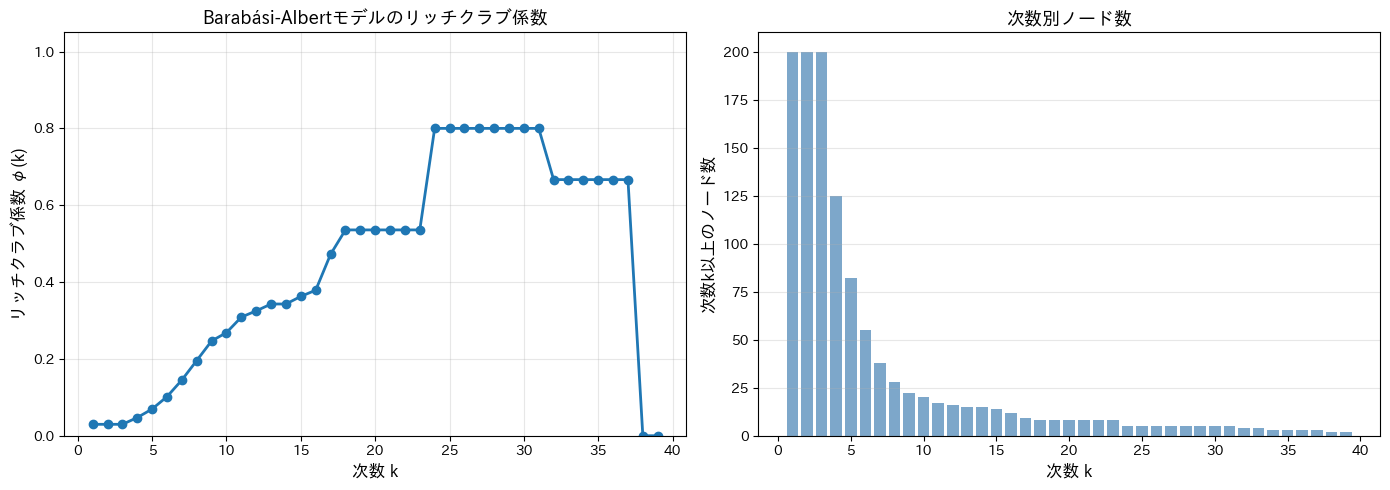

リッチクラブ係数の解釈:
  φ(k) = 1: 次数k以上のノードが完全連結
  φ(k)が高い: 高次数ノード同士が密に接続（リッチクラブ構造）

  最大次数: 39
  φ(k)の範囲: 0.000 - 0.800


In [3]:
def calculate_rich_club_coefficient(G):
    """
    リッチクラブ係数を各次数kについて計算
    """
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    
    rich_club = {}
    
    for k in range(1, max_degree + 1):
        # 次数k以上のノード
        nodes_k = [n for n, d in degrees.items() if d >= k]
        n_k = len(nodes_k)
        
        if n_k < 2:
            continue
        
        # これらのノード間のエッジ数
        subgraph = G.subgraph(nodes_k)
        e_k = subgraph.number_of_edges()
        
        # リッチクラブ係数
        max_edges = n_k * (n_k - 1) / 2
        phi_k = e_k / max_edges if max_edges > 0 else 0
        
        rich_club[k] = {
            'phi': phi_k,
            'n_nodes': n_k,
            'n_edges': e_k
        }
    
    return rich_club

# NetworkXの組み込み関数との比較
G_ba = nx.barabasi_albert_graph(200, 3, seed=42)

# 自作関数
rc_custom = calculate_rich_club_coefficient(G_ba)

# NetworkX関数
rc_nx = nx.rich_club_coefficient(G_ba, normalized=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# リッチクラブ係数の推移
k_values = sorted(rc_custom.keys())
phi_values = [rc_custom[k]['phi'] for k in k_values]

axes[0].plot(k_values, phi_values, 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('次数 k', fontsize=12)
axes[0].set_ylabel('リッチクラブ係数 φ(k)', fontsize=12)
axes[0].set_title('Barabási-Albertモデルのリッチクラブ係数', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.05)

# ノード数の推移
n_nodes = [rc_custom[k]['n_nodes'] for k in k_values]
axes[1].bar(k_values, n_nodes, color='steelblue', alpha=0.7)
axes[1].set_xlabel('次数 k', fontsize=12)
axes[1].set_ylabel('次数k以上のノード数', fontsize=12)
axes[1].set_title('次数別ノード数', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("リッチクラブ係数の解釈:")
print("  φ(k) = 1: 次数k以上のノードが完全連結")
print("  φ(k)が高い: 高次数ノード同士が密に接続（リッチクラブ構造）")
print(f"\n  最大次数: {max(k_values)}")
print(f"  φ(k)の範囲: {min(phi_values):.3f} - {max(phi_values):.3f}")

## A14.3 正規化リッチクラブ係数

### ランダムネットワークとの比較

リッチクラブ係数は次数が高いほど自然に上昇する傾向があります。
真のリッチクラブ構造を検出するには、同じ次数分布を持つランダムネットワークと比較します：

$$\rho(k) = \frac{\phi(k)}{\phi_{random}(k)}$$

- $\rho(k) > 1$: リッチクラブ構造が存在
- $\rho(k) \approx 1$: ランダムと同程度
- $\rho(k) < 1$: リッチクラブ回避構造

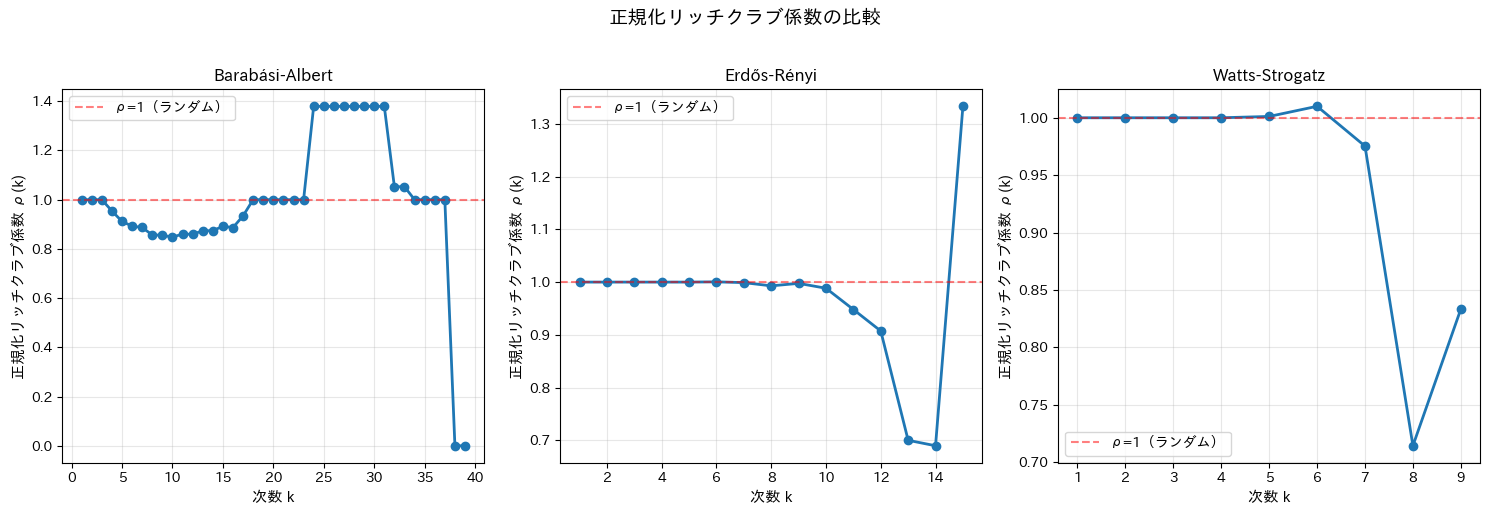

正規化リッチクラブ係数の解釈:
  ρ(k) > 1: リッチクラブ構造あり（高次数ノードが想定以上に接続）
  ρ(k) ≈ 1: ランダムと同程度
  ρ(k) < 1: リッチクラブ回避構造


In [4]:
def calculate_normalized_rich_club(G, n_random=10):
    """
    正規化リッチクラブ係数を計算
    次数分布を保持したランダムネットワークと比較
    """
    rc_original = calculate_rich_club_coefficient(G)
    
    # ランダムネットワークの平均リッチクラブ係数
    rc_random_all = defaultdict(list)
    
    for _ in range(n_random):
        # 次数分布を保持したランダム化
        G_random = G.copy()
        nx.double_edge_swap(G_random, nswap=G.number_of_edges() * 2, max_tries=G.number_of_edges() * 10)
        
        rc_rand = calculate_rich_club_coefficient(G_random)
        for k, data in rc_rand.items():
            rc_random_all[k].append(data['phi'])
    
    # 正規化係数
    normalized = {}
    for k in rc_original:
        if k in rc_random_all and len(rc_random_all[k]) > 0:
            phi_random = np.mean(rc_random_all[k])
            phi_random_std = np.std(rc_random_all[k])
            if phi_random > 0:
                normalized[k] = {
                    'rho': rc_original[k]['phi'] / phi_random,
                    'phi': rc_original[k]['phi'],
                    'phi_random': phi_random,
                    'phi_random_std': phi_random_std
                }
    
    return normalized

# 異なるネットワークで正規化リッチクラブ係数を計算
networks = {
    'Barabási-Albert': nx.barabasi_albert_graph(200, 3, seed=42),
    'Erdős-Rényi': nx.erdos_renyi_graph(200, 0.05, seed=42),
    'Watts-Strogatz': nx.watts_strogatz_graph(200, 6, 0.3, seed=42),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, G) in zip(axes, networks.items()):
    normalized = calculate_normalized_rich_club(G, n_random=5)
    
    k_values = sorted(normalized.keys())
    rho_values = [normalized[k]['rho'] for k in k_values]
    
    ax.plot(k_values, rho_values, 'o-', linewidth=2, markersize=6)
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='ρ=1（ランダム）')
    ax.set_xlabel('次数 k', fontsize=11)
    ax.set_ylabel('正規化リッチクラブ係数 ρ(k)', fontsize=11)
    ax.set_title(f'{name}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle('正規化リッチクラブ係数の比較', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("正規化リッチクラブ係数の解釈:")
print("  ρ(k) > 1: リッチクラブ構造あり（高次数ノードが想定以上に接続）")
print("  ρ(k) ≈ 1: ランダムと同程度")
print("  ρ(k) < 1: リッチクラブ回避構造")

## A14.4 リッチクラブの検出と可視化

### リッチクラブノードの特定

/tmp/ipykernel_5701/2978421126.py:79: UserWarning: Glyph 8805 (\N{GREATER-THAN OR EQUAL TO}) missing from font(s) IPAexGothic.
  plt.tight_layout()
/home/katzkawai/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8805 (\N{GREATER-THAN OR EQUAL TO}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


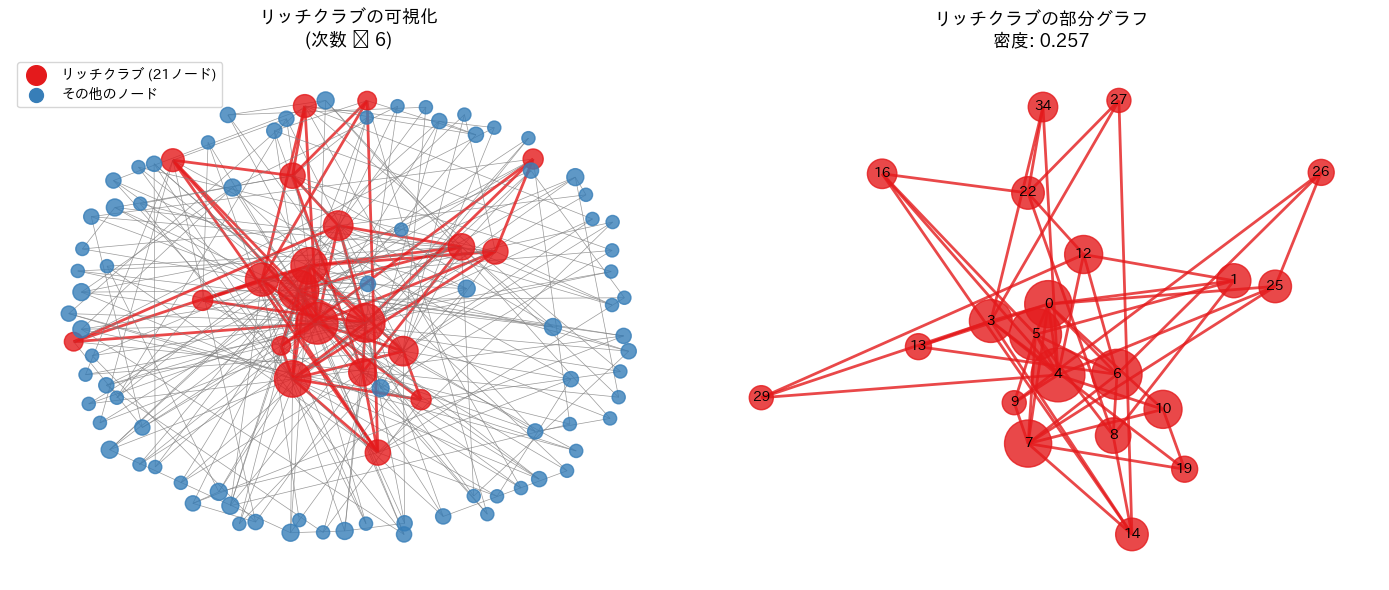

リッチクラブ統計:
  次数しきい値: 6
  リッチクラブノード数: 21
  リッチクラブ内エッジ数: 54
  リッチクラブ密度: 0.257


In [5]:
def identify_rich_club_nodes(G, k_threshold=None, percentile=90):
    """
    リッチクラブノードを特定
    
    Parameters:
    -----------
    G : networkx.Graph
    k_threshold : int, optional
        次数のしきい値（指定しない場合はパーセンタイルを使用）
    percentile : float
        使用するパーセンタイル（k_thresholdがNoneの場合）
    """
    degrees = dict(G.degree())
    
    if k_threshold is None:
        k_threshold = np.percentile(list(degrees.values()), percentile)
    
    rich_nodes = [n for n, d in degrees.items() if d >= k_threshold]
    
    # リッチクラブの統計
    subgraph = G.subgraph(rich_nodes)
    n_rich = len(rich_nodes)
    e_rich = subgraph.number_of_edges()
    max_edges = n_rich * (n_rich - 1) / 2 if n_rich > 1 else 0
    density = e_rich / max_edges if max_edges > 0 else 0
    
    return {
        'nodes': rich_nodes,
        'k_threshold': k_threshold,
        'n_nodes': n_rich,
        'n_edges': e_rich,
        'density': density
    }

# Barabási-Albertネットワークでリッチクラブを可視化
G = nx.barabasi_albert_graph(100, 3, seed=42)
rich_info = identify_rich_club_nodes(G, percentile=80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ネットワーク可視化
pos = nx.spring_layout(G, seed=42, k=1.5)
degrees = dict(G.degree())

# ノードの色とサイズ
node_colors = ['#e41a1c' if n in rich_info['nodes'] else '#377eb8' for n in G.nodes()]
node_sizes = [degrees[n] * 30 for n in G.nodes()]

# エッジの色（リッチクラブ内は赤）
edge_colors = []
for u, v in G.edges():
    if u in rich_info['nodes'] and v in rich_info['nodes']:
        edge_colors.append('#e41a1c')
    else:
        edge_colors.append('gray')

nx.draw(G, pos, ax=axes[0], node_color=node_colors, node_size=node_sizes,
        edge_color=edge_colors, alpha=0.8, width=[2 if c == '#e41a1c' else 0.5 for c in edge_colors])

axes[0].set_title(f'リッチクラブの可視化\n(次数 ≥ {rich_info["k_threshold"]:.0f})', fontsize=13)
axes[0].scatter([], [], c='#e41a1c', s=200, label=f'リッチクラブ ({rich_info["n_nodes"]}ノード)')
axes[0].scatter([], [], c='#377eb8', s=100, label='その他のノード')
axes[0].legend(loc='upper left')

# リッチクラブの部分グラフ
subgraph = G.subgraph(rich_info['nodes'])
pos_sub = {n: pos[n] for n in rich_info['nodes']}

nx.draw(subgraph, pos_sub, ax=axes[1], node_color='#e41a1c',
        node_size=[degrees[n] * 50 for n in subgraph.nodes()],
        edge_color='#e41a1c', width=2, alpha=0.8)

# ノードラベル
labels = {n: str(n) for n in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos_sub, labels, ax=axes[1], font_size=10)

axes[1].set_title(f'リッチクラブの部分グラフ\n密度: {rich_info["density"]:.3f}', fontsize=13)

plt.tight_layout()
plt.show()

print(f"リッチクラブ統計:")
print(f"  次数しきい値: {rich_info['k_threshold']:.0f}")
print(f"  リッチクラブノード数: {rich_info['n_nodes']}")
print(f"  リッチクラブ内エッジ数: {rich_info['n_edges']}")
print(f"  リッチクラブ密度: {rich_info['density']:.3f}")

## A14.5 リッチクラブと次数相関

### 次数同類性との関係

リッチクラブ現象は次数同類性（degree assortativity）と関連していますが、異なる概念です。

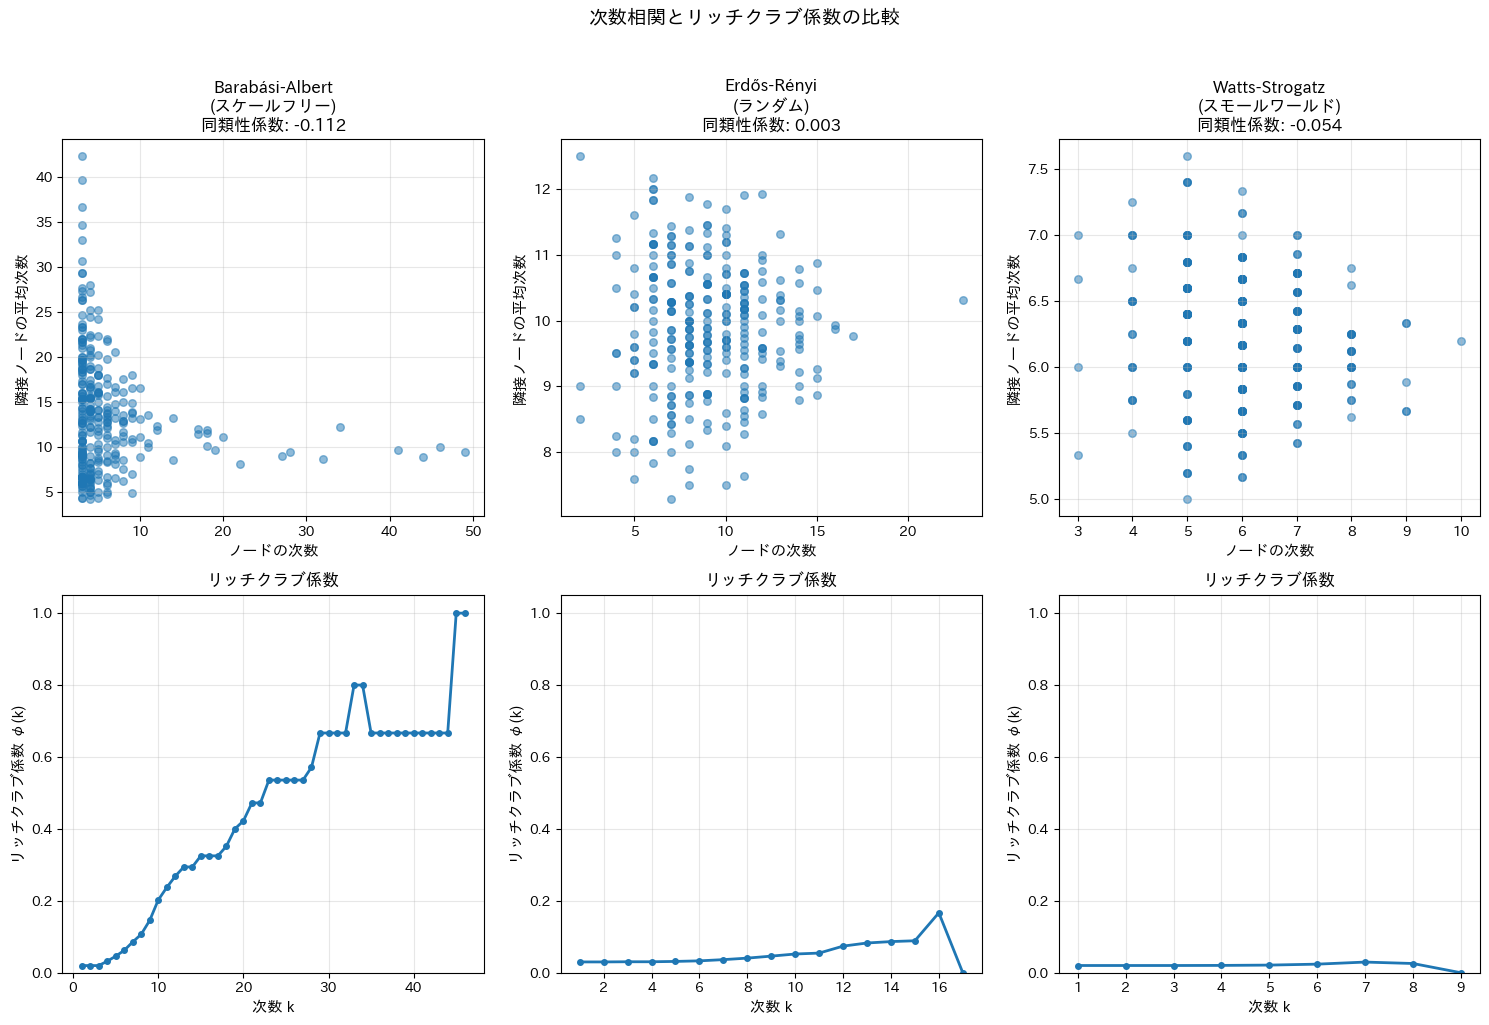

次数同類性係数の解釈:
  r > 0: 同類的（高次数同士、低次数同士が接続）
  r < 0: 異類的（高次数と低次数が接続）
  r ≈ 0: 相関なし


In [6]:
def analyze_degree_correlation(G):
    """
    次数相関分析
    """
    # 次数同類性係数
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # 隣接ノードの平均次数
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    degrees = dict(G.degree())
    
    return assortativity, degrees, avg_neighbor_degree

# 異なるネットワークの比較
networks = {
    'Barabási-Albert\n(スケールフリー)': nx.barabasi_albert_graph(300, 3, seed=42),
    'Erdős-Rényi\n(ランダム)': nx.erdos_renyi_graph(300, 0.03, seed=42),
    'Watts-Strogatz\n(スモールワールド)': nx.watts_strogatz_graph(300, 6, 0.3, seed=42),
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for col, (name, G) in enumerate(networks.items()):
    # 次数相関分析
    assortativity, degrees, avg_neighbor = analyze_degree_correlation(G)
    
    # 上段: 次数 vs 隣接ノード平均次数
    x = [degrees[n] for n in G.nodes()]
    y = [avg_neighbor[n] for n in G.nodes()]
    
    axes[0, col].scatter(x, y, alpha=0.5, s=30)
    axes[0, col].set_xlabel('ノードの次数', fontsize=11)
    axes[0, col].set_ylabel('隣接ノードの平均次数', fontsize=11)
    axes[0, col].set_title(f'{name}\n同類性係数: {assortativity:.3f}', fontsize=12)
    axes[0, col].grid(True, alpha=0.3)
    
    # 下段: リッチクラブ係数
    rc = calculate_rich_club_coefficient(G)
    k_values = sorted(rc.keys())
    phi_values = [rc[k]['phi'] for k in k_values]
    
    axes[1, col].plot(k_values, phi_values, 'o-', linewidth=2, markersize=4)
    axes[1, col].set_xlabel('次数 k', fontsize=11)
    axes[1, col].set_ylabel('リッチクラブ係数 φ(k)', fontsize=11)
    axes[1, col].set_title('リッチクラブ係数', fontsize=12)
    axes[1, col].grid(True, alpha=0.3)
    axes[1, col].set_ylim(0, 1.05)

plt.suptitle('次数相関とリッチクラブ係数の比較', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("次数同類性係数の解釈:")
print("  r > 0: 同類的（高次数同士、低次数同士が接続）")
print("  r < 0: 異類的（高次数と低次数が接続）")
print("  r ≈ 0: 相関なし")

## A14.6 リッチクラブの影響

### ネットワーク機能への影響

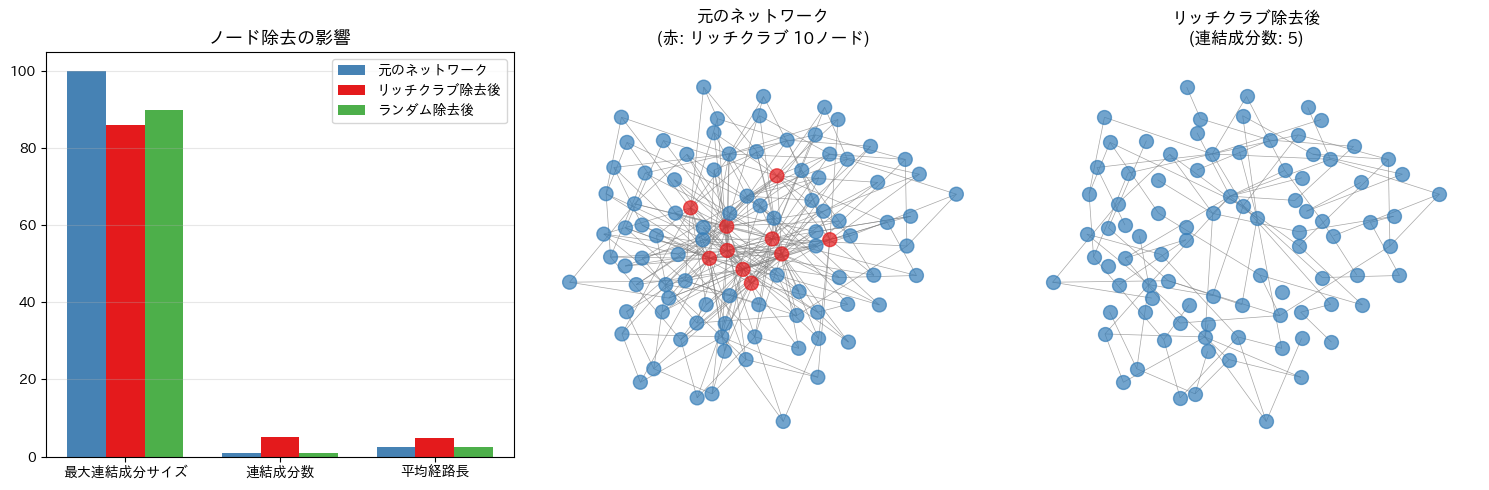

リッチクラブ除去の影響:
  除去ノード数: 10 (10.0%)

元のネットワーク:
  平均経路長: 2.515

リッチクラブ除去後:
  最大連結成分: 86ノード
  連結成分数: 5
  平均経路長: 4.818

ランダム除去後:
  最大連結成分: 90ノード
  連結成分数: 1


In [7]:
def analyze_rich_club_impact(G, rich_nodes):
    """
    リッチクラブがネットワーク機能に与える影響を分析
    """
    # 元のネットワーク統計
    original_stats = {
        'avg_path': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf'),
        'clustering': nx.average_clustering(G),
        'diameter': nx.diameter(G) if nx.is_connected(G) else float('inf')
    }
    
    # リッチクラブを除去した場合
    G_no_rich = G.copy()
    G_no_rich.remove_nodes_from(rich_nodes)
    
    if G_no_rich.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G_no_rich), key=len)
        G_no_rich_cc = G_no_rich.subgraph(largest_cc).copy()
        
        no_rich_stats = {
            'avg_path': nx.average_shortest_path_length(G_no_rich_cc) if len(largest_cc) > 1 else 0,
            'clustering': nx.average_clustering(G_no_rich),
            'n_components': nx.number_connected_components(G_no_rich),
            'largest_cc_size': len(largest_cc)
        }
    else:
        no_rich_stats = None
    
    # 同数のランダムノードを除去した場合（比較用）
    random_nodes = random.sample([n for n in G.nodes() if n not in rich_nodes], 
                                  min(len(rich_nodes), len(G.nodes()) - len(rich_nodes)))
    G_no_random = G.copy()
    G_no_random.remove_nodes_from(random_nodes)
    
    if G_no_random.number_of_nodes() > 0:
        largest_cc_rand = max(nx.connected_components(G_no_random), key=len)
        G_no_random_cc = G_no_random.subgraph(largest_cc_rand).copy()
        
        no_random_stats = {
            'avg_path': nx.average_shortest_path_length(G_no_random_cc) if len(largest_cc_rand) > 1 else 0,
            'clustering': nx.average_clustering(G_no_random),
            'n_components': nx.number_connected_components(G_no_random),
            'largest_cc_size': len(largest_cc_rand)
        }
    else:
        no_random_stats = None
    
    return original_stats, no_rich_stats, no_random_stats

# 分析実行
G = nx.barabasi_albert_graph(100, 3, seed=42)
rich_info = identify_rich_club_nodes(G, percentile=90)

original, no_rich, no_random = analyze_rich_club_impact(G, rich_info['nodes'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 比較データ
metrics = ['最大連結成分サイズ', '連結成分数', '平均経路長']
original_vals = [G.number_of_nodes(), 1, original['avg_path']]
no_rich_vals = [no_rich['largest_cc_size'], no_rich['n_components'], no_rich['avg_path']]
no_random_vals = [no_random['largest_cc_size'], no_random['n_components'], no_random['avg_path']]

x = np.arange(3)
width = 0.25

axes[0].bar(x - width, original_vals, width, label='元のネットワーク', color='steelblue')
axes[0].bar(x, no_rich_vals, width, label='リッチクラブ除去後', color='#e41a1c')
axes[0].bar(x + width, no_random_vals, width, label='ランダム除去後', color='#4daf4a')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_title('ノード除去の影響', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# リッチクラブ除去後のネットワーク
G_vis = G.copy()
pos = nx.spring_layout(G_vis, seed=42)

# 元のネットワーク（リッチクラブをハイライト）
node_colors = ['#e41a1c' if n in rich_info['nodes'] else '#377eb8' for n in G_vis.nodes()]
nx.draw(G_vis, pos, ax=axes[1], node_color=node_colors, node_size=100,
        edge_color='gray', alpha=0.7, width=0.5)
axes[1].set_title(f'元のネットワーク\n(赤: リッチクラブ {len(rich_info["nodes"])}ノード)', fontsize=12)

# リッチクラブ除去後
G_removed = G.copy()
G_removed.remove_nodes_from(rich_info['nodes'])
pos_removed = {n: pos[n] for n in G_removed.nodes()}

nx.draw(G_removed, pos_removed, ax=axes[2], node_color='#377eb8', node_size=100,
        edge_color='gray', alpha=0.7, width=0.5)
axes[2].set_title(f'リッチクラブ除去後\n(連結成分数: {no_rich["n_components"]})', fontsize=12)

plt.tight_layout()
plt.show()

print(f"リッチクラブ除去の影響:")
print(f"  除去ノード数: {len(rich_info['nodes'])} ({len(rich_info['nodes'])/G.number_of_nodes()*100:.1f}%)")
print(f"\n元のネットワーク:")
print(f"  平均経路長: {original['avg_path']:.3f}")
print(f"\nリッチクラブ除去後:")
print(f"  最大連結成分: {no_rich['largest_cc_size']}ノード")
print(f"  連結成分数: {no_rich['n_components']}")
print(f"  平均経路長: {no_rich['avg_path']:.3f}")
print(f"\nランダム除去後:")
print(f"  最大連結成分: {no_random['largest_cc_size']}ノード")
print(f"  連結成分数: {no_random['n_components']}")

## A14.7 実世界ネットワークでのリッチクラブ

### 空手クラブネットワークの分析

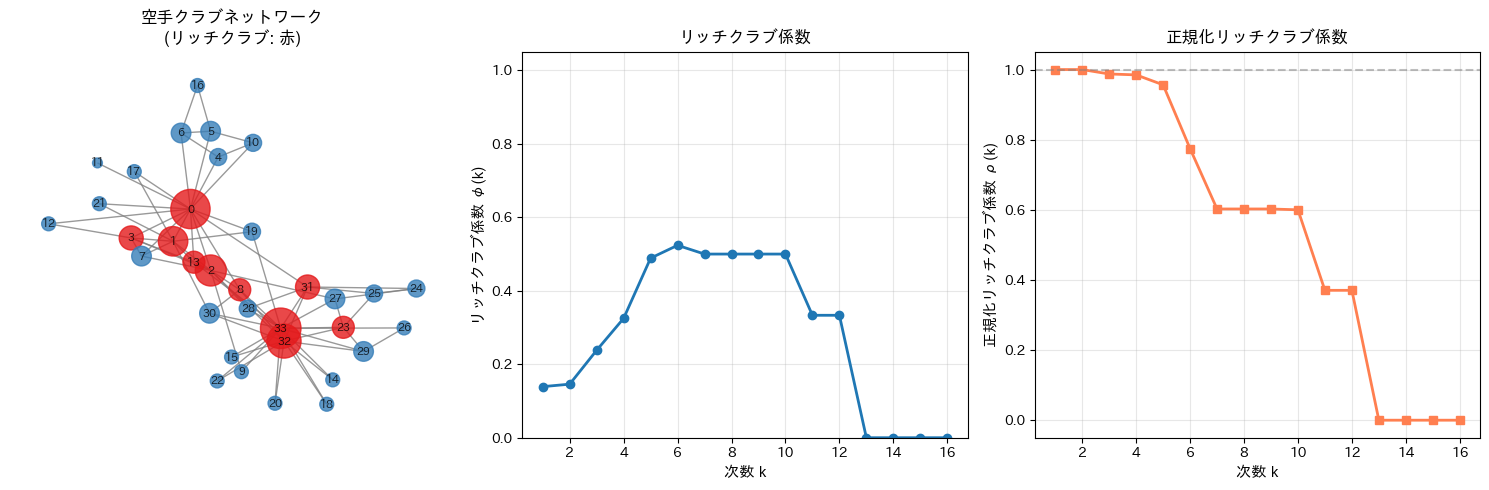

空手クラブネットワークのリッチクラブ分析:
  ノード数: 34
  エッジ数: 78
  リッチクラブノード: [0, 1, 2, 3, 8, 13, 23, 31, 32, 33]
  リッチクラブ密度: 0.489

  リッチクラブノードはリーダー（ノード0と33）を含む


In [8]:
# 空手クラブネットワーク
G_karate = nx.karate_club_graph()

# リッチクラブ分析
rc_karate = calculate_rich_club_coefficient(G_karate)
normalized_karate = calculate_normalized_rich_club(G_karate, n_random=10)
rich_info_karate = identify_rich_club_nodes(G_karate, percentile=75)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ネットワーク可視化
pos = nx.spring_layout(G_karate, seed=42)
degrees = dict(G_karate.degree())

node_colors = ['#e41a1c' if n in rich_info_karate['nodes'] else '#377eb8' for n in G_karate.nodes()]
node_sizes = [degrees[n] * 50 for n in G_karate.nodes()]

nx.draw(G_karate, pos, ax=axes[0], node_color=node_colors, node_size=node_sizes,
        edge_color='gray', alpha=0.8, width=1, with_labels=True, font_size=8)
axes[0].set_title(f'空手クラブネットワーク\n(リッチクラブ: 赤)', fontsize=12)

# リッチクラブ係数
k_values = sorted(rc_karate.keys())
phi_values = [rc_karate[k]['phi'] for k in k_values]

axes[1].plot(k_values, phi_values, 'o-', linewidth=2, markersize=6)
axes[1].set_xlabel('次数 k', fontsize=11)
axes[1].set_ylabel('リッチクラブ係数 φ(k)', fontsize=11)
axes[1].set_title('リッチクラブ係数', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.05)

# 正規化リッチクラブ係数
k_norm = sorted(normalized_karate.keys())
rho_values = [normalized_karate[k]['rho'] for k in k_norm]

axes[2].plot(k_norm, rho_values, 's-', linewidth=2, markersize=6, color='coral')
axes[2].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('次数 k', fontsize=11)
axes[2].set_ylabel('正規化リッチクラブ係数 ρ(k)', fontsize=11)
axes[2].set_title('正規化リッチクラブ係数', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"空手クラブネットワークのリッチクラブ分析:")
print(f"  ノード数: {G_karate.number_of_nodes()}")
print(f"  エッジ数: {G_karate.number_of_edges()}")
print(f"  リッチクラブノード: {rich_info_karate['nodes']}")
print(f"  リッチクラブ密度: {rich_info_karate['density']:.3f}")
print(f"\n  リッチクラブノードはリーダー（ノード0と33）を含む")

## A14.8 まとめ

### リッチクラブ現象の主要概念

| 概念 | 説明 |
|------|------|
| リッチクラブ現象 | 高次数ノード同士が密に接続する傾向 |
| リッチクラブ係数 φ(k) | 次数k以上のノード間のエッジ密度 |
| 正規化係数 ρ(k) | ランダムネットワークとの比較 |
| リッチクラブ構造 | ρ(k) > 1 となる範囲 |

### リッチクラブの影響

1. **ネットワーク頑健性**
   - リッチクラブは効率的な情報伝達を可能にする
   - しかし標的攻撃に対して脆弱

2. **情報伝播**
   - リッチクラブを通じた高速な情報拡散
   - ボトルネックにもなりうる

3. **社会的影響**
   - 権力・影響力の集中
   - エリートネットワークの形成

---

## 練習問題

### 問題1: リッチクラブ係数の手計算

以下の小さなネットワークについて、k=2, k=3, k=4のリッチクラブ係数を手計算で求めてください。

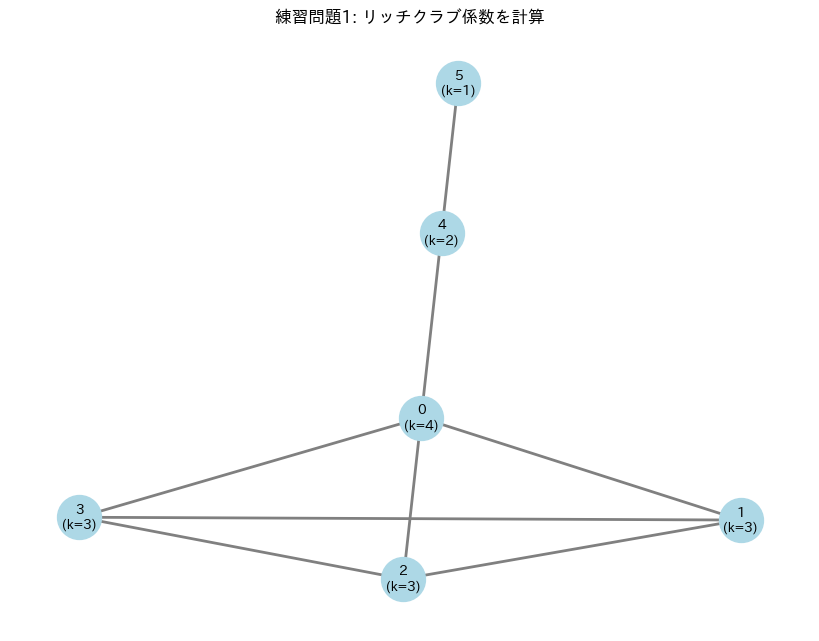

各ノードの次数:
  ノード0: 次数4
  ノード1: 次数3
  ノード2: 次数3
  ノード3: 次数3
  ノード4: 次数2
  ノード5: 次数1


In [9]:
# 練習用ネットワーク
G_prob1 = nx.Graph()
G_prob1.add_edges_from([
    (0, 1), (0, 2), (0, 3), (0, 4),  # ノード0は次数4
    (1, 2), (1, 3),                   # ノード1は次数3
    (2, 3),                           # ノード2は次数3
    (4, 5)                            # ノード3は次数3、ノード4は次数2、ノード5は次数1
])

# ネットワークを表示
pos = nx.spring_layout(G_prob1, seed=42)
degrees = dict(G_prob1.degree())
labels = {n: f'{n}\n(k={degrees[n]})' for n in G_prob1.nodes()}

plt.figure(figsize=(8, 6))
nx.draw(G_prob1, pos, labels=labels, node_color='lightblue',
        node_size=1000, font_size=10, edge_color='gray', width=2)
plt.title('練習問題1: リッチクラブ係数を計算')
plt.show()

print("各ノードの次数:")
for n, d in sorted(degrees.items()):
    print(f"  ノード{n}: 次数{d}")

# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
print("手計算:")

# k=2: 次数2以上のノード {0,1,2,3,4}
print("\nk=2:")
print("  対象ノード: {0,1,2,3,4} (5ノード)")
print("  これらのノード間のエッジ: (0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(2,3) = 7本")
print("  最大エッジ数: 5*4/2 = 10")
print("  φ(2) = 7/10 = 0.700")

# k=3: 次数3以上のノード {0,1,2,3}
print("\nk=3:")
print("  対象ノード: {0,1,2,3} (4ノード)")
print("  これらのノード間のエッジ: (0,1),(0,2),(0,3),(1,2),(1,3),(2,3) = 6本")
print("  最大エッジ数: 4*3/2 = 6")
print("  φ(3) = 6/6 = 1.000")

# k=4: 次数4以上のノード {0}
print("\nk=4:")
print("  対象ノード: {0} (1ノード)")
print("  1ノードでは係数計算不可")

# NetworkXで検証
print("\nNetworkXで検証:")
rc = calculate_rich_club_coefficient(G_prob1)
for k in [2, 3]:
    if k in rc:
        print(f"  φ({k}) = {rc[k]['phi']:.3f}")
```
</details>

### 問題2: リッチクラブ構造の比較

Barabási-Albertモデル（m=2, m=4, m=6）で生成した3つのネットワーク(n=200)について、
リッチクラブ係数を比較し、パラメータmがリッチクラブ構造に与える影響を分析してください。

In [10]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
m_values = [2, 4, 6]
n = 200

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, m in zip(axes, m_values):
    G = nx.barabasi_albert_graph(n, m, seed=42)
    rc = calculate_rich_club_coefficient(G)
    
    k_values = sorted(rc.keys())
    phi_values = [rc[k]['phi'] for k in k_values]
    
    ax.plot(k_values, phi_values, 'o-', linewidth=2, markersize=5)
    ax.set_xlabel('次数 k')
    ax.set_ylabel('リッチクラブ係数 φ(k)')
    ax.set_title(f'BA(n={n}, m={m})\n平均次数={2*m:.0f}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)

plt.suptitle('BAモデルのパラメータmとリッチクラブ係数', fontsize=14)
plt.tight_layout()
plt.show()

print("考察:")
print("  mが大きいほど平均次数が高く、ネットワークが密になる")
print("  mが大きいとリッチクラブ係数が全体的に高くなる傾向")
print("  これは密なネットワークでは高次数ノード間の接続が増えるため")
```
</details>

### 問題3: リッチクラブと情報伝播

リッチクラブノードから情報を発信した場合と、ランダムなノードから発信した場合で、
情報がネットワーク全体に広がる速度を比較してください。

ヒント: 単純な拡散モデル（各ステップで隣接ノードに確率的に伝播）を使用してください。

In [11]:
# ここにコードを書いてください


<details>
<summary>解答例を見る</summary>

```python
def simulate_diffusion(G, seed_nodes, p_spread=0.3, max_steps=50):
    """情報拡散シミュレーション"""
    informed = set(seed_nodes)
    history = [len(informed)]
    
    for step in range(max_steps):
        new_informed = set()
        for node in informed:
            for neighbor in G.neighbors(node):
                if neighbor not in informed and random.random() < p_spread:
                    new_informed.add(neighbor)
        
        if not new_informed:
            history.extend([len(informed)] * (max_steps - step))
            break
        
        informed.update(new_informed)
        history.append(len(informed))
    
    return history

# ネットワーク生成
G = nx.barabasi_albert_graph(200, 3, seed=42)
rich_info = identify_rich_club_nodes(G, percentile=90)

n_trials = 20
n_seeds = 3

# リッチクラブからの拡散
rich_histories = []
for _ in range(n_trials):
    seeds = random.sample(rich_info['nodes'], min(n_seeds, len(rich_info['nodes'])))
    history = simulate_diffusion(G, seeds)
    rich_histories.append(history)

# ランダムノードからの拡散
random_histories = []
non_rich = [n for n in G.nodes() if n not in rich_info['nodes']]
for _ in range(n_trials):
    seeds = random.sample(non_rich, n_seeds)
    history = simulate_diffusion(G, seeds)
    random_histories.append(history)

# 結果の可視化
fig, ax = plt.subplots(figsize=(10, 6))

# 平均を計算
max_len = max(max(len(h) for h in rich_histories), max(len(h) for h in random_histories))
rich_padded = [h + [h[-1]] * (max_len - len(h)) for h in rich_histories]
random_padded = [h + [h[-1]] * (max_len - len(h)) for h in random_histories]

rich_mean = np.mean(rich_padded, axis=0) / G.number_of_nodes() * 100
random_mean = np.mean(random_padded, axis=0) / G.number_of_nodes() * 100

ax.plot(rich_mean, 'r-', linewidth=2, label='リッチクラブから発信')
ax.plot(random_mean, 'b-', linewidth=2, label='ランダムノードから発信')
ax.set_xlabel('ステップ')
ax.set_ylabel('情報到達率 (%)')
ax.set_title('発信源による情報拡散速度の違い')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"結論:")
print(f"  リッチクラブからの発信: より速く広範囲に拡散")
print(f"  ランダムノードからの発信: 拡散が遅い")
print(f"\n  リッチクラブノードは多くの接続を持つため、")
print(f"  情報が効率的にネットワーク全体に広がる")
```
</details>

---

## 参考文献

1. Zhou, S., & Mondragón, R. J. (2004). The rich-club phenomenon in the Internet topology. IEEE Communications Letters, 8(3), 180-182.

2. Colizza, V., Flammini, A., Serrano, M. A., & Vespignani, A. (2006). Detecting rich-club ordering in complex networks. Nature Physics, 2(2), 110-115.

3. Van Den Heuvel, M. P., & Sporns, O. (2011). Rich-club organization of the human connectome. Journal of Neuroscience, 31(44), 15775-15786.

4. Opsahl, T., Colizza, V., Panzarasa, P., & Ramasco, J. J. (2008). Prominence and control: the weighted rich-club effect. Physical Review Letters, 101(16), 168702.